In [2]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# 2. Load the data
file_path = "../data/raw/transactions.csv"  # adjust if needed
df = pd.read_csv(file_path)

# 3. Quick overview
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nTypes:\n", df.dtypes)
df.head()

Shape: (95662, 16)

Columns:
 Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

Types:
 TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [3]:
# Summary statistics
df.describe(include='all').T

# Count missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

# Unique values per column
df.nunique().sort_values(ascending=False)

TransactionId           95662
BatchId                 94809
TransactionStartTime    94556
CustomerId               3742
AccountId                3633
SubscriptionId           3627
Amount                   1676
Value                    1517
ProductId                  23
ProductCategory             9
ProviderId                  6
ChannelId                   4
PricingStrategy             4
FraudResult                 2
CountryCode                 1
CurrencyCode                1
dtype: int64

In [6]:
df[df['Amount'] < 0][['Amount', 'Value']].head(10)

,Amount,Value
1,-20.0,20
4,-644.0,644
7,-500.0,500
11,-40.0,40
18,-10.0,10
20,-25.0,25
22,-25.0,25
25,-10.0,10
28,-70.0,70
31,-100.0,100


In [10]:
# Drop value (redundant)
# df = df.drop(columns=['Value'])

# Optionally: Create separate features for money in and out
df['Amount_Pos'] = df['Amount'].apply(lambda x: x if x > 0 else 0)
df['Amount_Neg'] = df['Amount'].apply(lambda x: -x if x < 0 else 0)  # keep it positive

###  Numerical Distributions

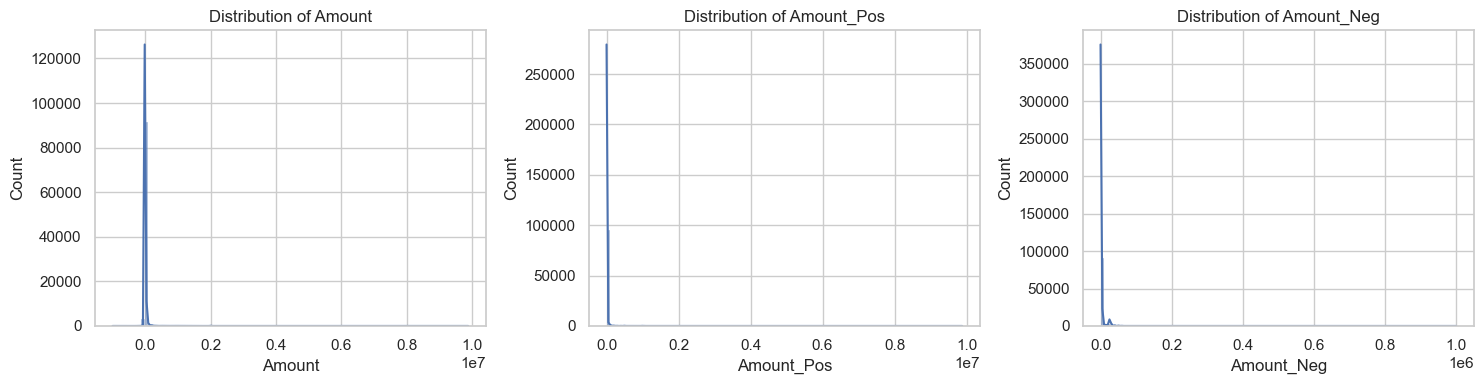

In [11]:
# Plot histograms
numerical_cols = ['Amount', 'Amount_Pos', 'Amount_Neg']
plt.figure(figsize=(15, 4))

for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=100, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### Visualize with Log Scale

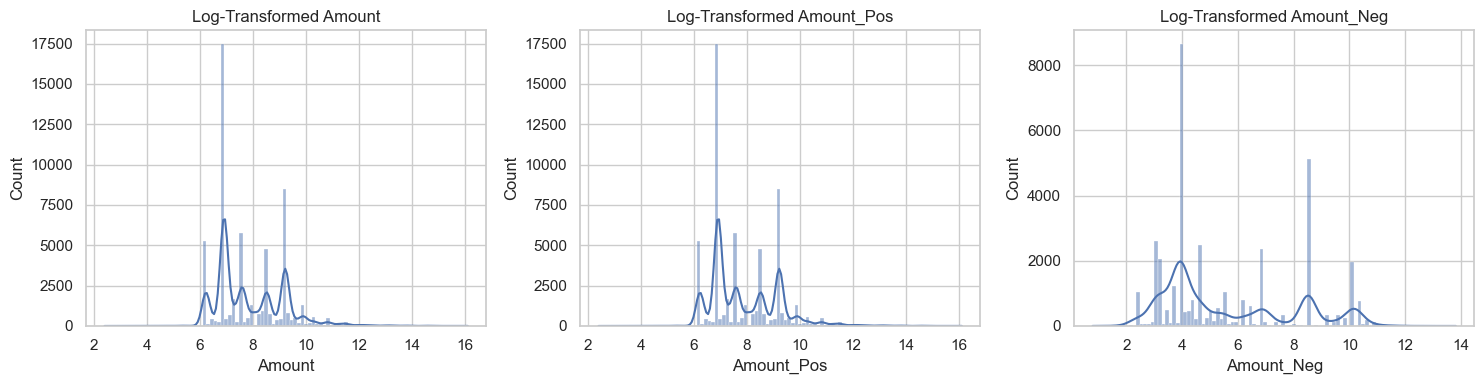

In [14]:
# re-plot with a logarithmic scale to reveal the hidden structure.

plt.figure(figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    transformed = df[df[col] > 0][col].apply(np.log1p)  # log1p to avoid log(0)
    sns.histplot(transformed, bins=100, kde=True)
    plt.title(f'Log-Transformed {col}')

plt.tight_layout()
plt.show()

### Barplots of Top Categorical Features

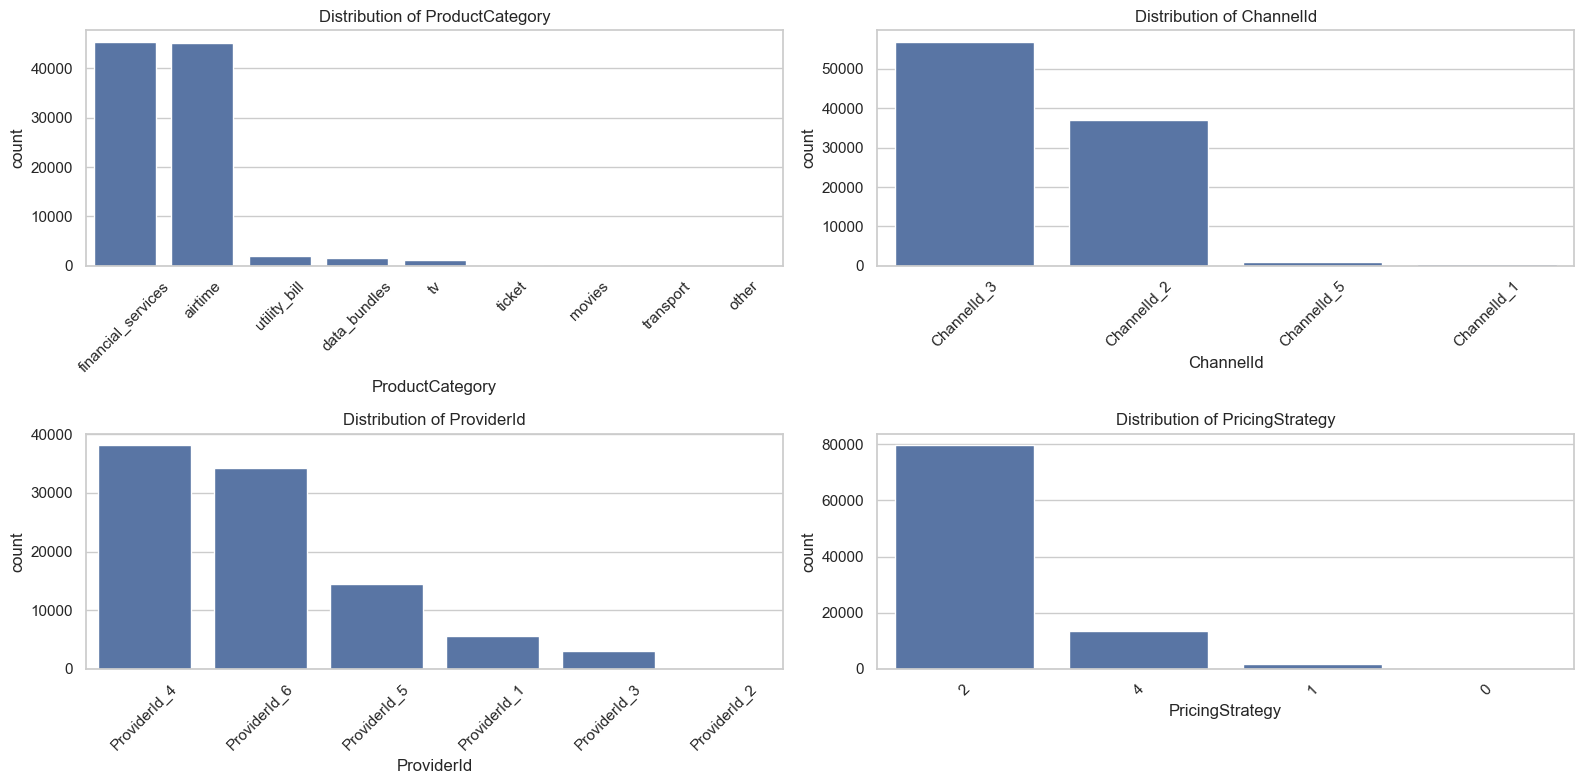

In [15]:
categorical_cols = ['ProductCategory', 'ChannelId', 'ProviderId', 'PricingStrategy']

plt.figure(figsize=(16, 8))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## ✍️ Summary: Top EDA Insights

    Transaction Behavior is Extremely Skewed
    Transaction amounts are heavily right-skewed, with most purchases clustered around 400–3,000 units and a long tail up to 160,000+. Refunds are smaller on average but widely distributed.

    Airtime and Financial Services Dominate Product Usage
    Over 85% of user activity falls into these two product categories. The rest (like TV, transport, ticketing) are nearly inactive and may not contribute meaningfully to the model.

    Mobile Channels Dominate Engagement
    Most transactions occur through ChannelId_3 and ChannelId_2, likely indicating a mobile-first customer base. Web-based usage is rare and may suggest a different risk profile.

    Few Providers Drive Most Activity
    Provider IDs 4 and 6 cover the bulk of transactions. This concentration suggests potential for merchant-specific risk features, but rare providers may be excluded or binned.

    Currency and Country Codes Are Constant
    With no variation in these fields, they do not contribute any predictive power and can safely be dropped from the modeling pipeline.